# Multilayer Neural Networks - Pytorch (From Scratch)

In [1]:
import torch
from torch import nn
from torchvision import datasets
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu' # will select 'cuda' is gpu is available otherwise 'cpu'
print('Chosen device:', device)

Chosen device: cuda


## Getting our dataset

In [2]:
# transform = lambda image: torch.FloatTensor(image.getdata())/255.0
# or 
def transform(image):
    return torch.FloatTensor(image.getdata())/255.0

train_mnist = datasets.FashionMNIST(root = '~/data', train = True, transform = transform, download = True)
test_mnist = datasets.FashionMNIST(root = '~/data', train = False, transform = transform, download = True)

In [3]:
image, label = train_mnist[0]
print(image.shape, label)

torch.Size([784]) 9


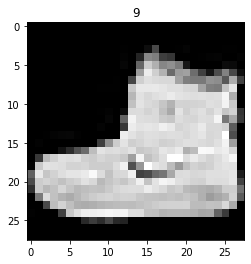

In [4]:
plt.imshow(image.reshape(28, 28), cmap = 'gray')
plt.title(label)
plt.show()

## Creating data loader for training and testing

In [5]:
batch_size = 64
train_data = torch.utils.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = torch.utils.data.DataLoader(test_mnist, batch_size = batch_size, shuffle = False)

print('No of batches for batch size {} is {}'.format(batch_size, len(train_data)))

No of batches for batch size 64 is 938


## Building the model

In [6]:
# initializing parameters with mean of 0 and stddev of 0.1

W1 = nn.Parameter(torch.normal(0, 0.1, [784, 256], device = device))
b1 = nn.Parameter(torch.normal(0, 0.1, [256], device = device))

W2 = nn.Parameter(torch.normal(0, 0.1, [256, 128], device = device))
b2 = nn.Parameter(torch.normal(0, 0.1, [128], device = device))

W3 = nn.Parameter(torch.normal(0, 0.1, [128, 10], device = device))
b3 = nn.Parameter(torch.normal(0, 0.1, [10], device = device))

params = [W1, b1, W2, b2, W3, b3]

def relu(linear):
    linear[linear < 0] = 0
    return linear

def softmax(linear):
    exp = torch.exp(linear - torch.max(linear, axis = 1)[0].reshape(-1, 1))
    # subtracting max for numerical statbility... (it does not affect the outputs)
    norms = torch.sum(exp, axis = 1).reshape(-1, 1)
    return exp / norms

def neuralnetworks(inputs):
    layer1 = relu(torch.mm(inputs, W1) + b1)
    layer2 = relu(torch.mm(layer1, W2) + b2)
    return softmax(torch.mm(layer2, W3) + b3)

## Defining our objective function

In [7]:
def categoricalcrossentropy(predictions, labels):
    return -torch.sum(labels * torch.log(predictions))

## Defining our optimizer (Gradient Descent)

In [8]:
def sgd(params, lr):
    with torch.no_grad():
        # doing all the parameter updated inside torch.no_grad, because we don't want to record any computation of sgd for backward pass....
        for param in params:
            param -= lr * param.grad
            param.grad.zero_()
            # zeroing the gradient of after each update so that it would't affect the gradients of for the next update

## Defining our accuracy function

In [9]:
def accuracy(predictions, labels):
    return (predictions.argmax(1) == labels.argmax(1)).float().mean()

## Understanding one hot representation

- If the label is 0 then it's one hot vector is [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

- If the label is 1 then it's one hot vector is [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

- If the label is 2 then it's one hot vector is [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [10]:
import torch.nn.functional as F

def onehot(label):
    return F.one_hot(label, 10).float()

In [11]:
epochs = 20
num_batches = len(train_data)
learning_rate = .001 # you can change it to 0.01 for faster training
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in train_data:
        features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
        labels = onehot(labels.to(device)) # .to(device) put labels stored in cpu to device(which we have initialized above)
        
        outputs = neuralnetworks(features)
        loss = categoricalcrossentropy(outputs, labels)
        loss.backward()

        sgd(params, learning_rate)
        
        cumulative_loss += loss        
        cumulative_acc += accuracy(outputs, labels)

    print(f'Epoch: {epoch} Loss: {cumulative_loss/num_batches} Accuracy: {cumulative_acc/num_batches}')
    losses.append(cumulative_loss/num_batches)
    accs.append(cumulative_acc/num_batches)

Epoch: 0 Loss: 36.7842903137207 Accuracy: 0.8006396889686584
Epoch: 1 Loss: 26.418485641479492 Accuracy: 0.853611409664154
Epoch: 2 Loss: 23.678926467895508 Accuracy: 0.8672541379928589
Epoch: 3 Loss: 22.025747299194336 Accuracy: 0.8761993646621704
Epoch: 4 Loss: 20.6820068359375 Accuracy: 0.8821129202842712
Epoch: 5 Loss: 19.62018585205078 Accuracy: 0.8879430890083313
Epoch: 6 Loss: 18.873184204101562 Accuracy: 0.8910248279571533
Epoch: 7 Loss: 17.991788864135742 Accuracy: 0.8968050479888916
Epoch: 8 Loss: 17.24404525756836 Accuracy: 0.9014192819595337
Epoch: 9 Loss: 16.631868362426758 Accuracy: 0.9046841859817505
Epoch: 10 Loss: 16.075313568115234 Accuracy: 0.9082822799682617
Epoch: 11 Loss: 15.572749137878418 Accuracy: 0.9106143712997437
Epoch: 12 Loss: 15.081428527832031 Accuracy: 0.9141791462898254
Epoch: 13 Loss: 14.567258834838867 Accuracy: 0.9172941446304321
Epoch: 14 Loss: 14.04989242553711 Accuracy: 0.9203425049781799
Epoch: 15 Loss: 13.69704532623291 Accuracy: 0.920792281627

## Lets see test accuracy

In [12]:
acc = 0.0
test_batches = len(test_data)
for features, labels in test_data:
    features = features.to(device) # .to(device) put features stored in cpu to device(which we have initialized above)
    labels = onehot(labels.to(device)) # .to(device) put labels stored in cpu to device(which we have initialized above)
    outputs = neuralnetworks(features)
    acc += accuracy(outputs, labels)
    
print(f'Test Accuracy: {acc/test_batches}')

Test Accuracy: 0.8798766136169434


In [13]:
def plot(losses = losses, accs = accs, model = neuralnetworks):
    samples = 16
    plt.plot(losses, 'r')
    plt.title('Loss during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(accs, 'g')
    plt.title('Accuracy during Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure(figsize = (15, 15))

    for i, example in enumerate(test_mnist, 1):
        features = example[0].to(device).reshape(1, -1)
        labels = example[1]
        outputs = model(features).argmax(1)
        plt.subplot(4, 4, i)
        plt.imshow(features[0].cpu().reshape(28, 28), cmap = 'gray')
        plt.axis('off')
        plt.title(f'Predicted: {outputs.item()}, Target: {labels}')
        if i == samples:
            break
    plt.show()

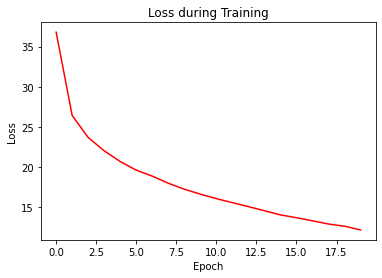

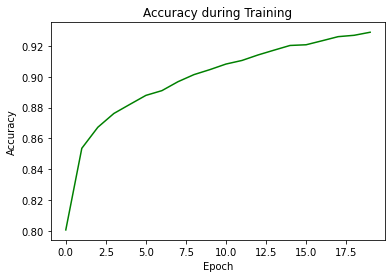

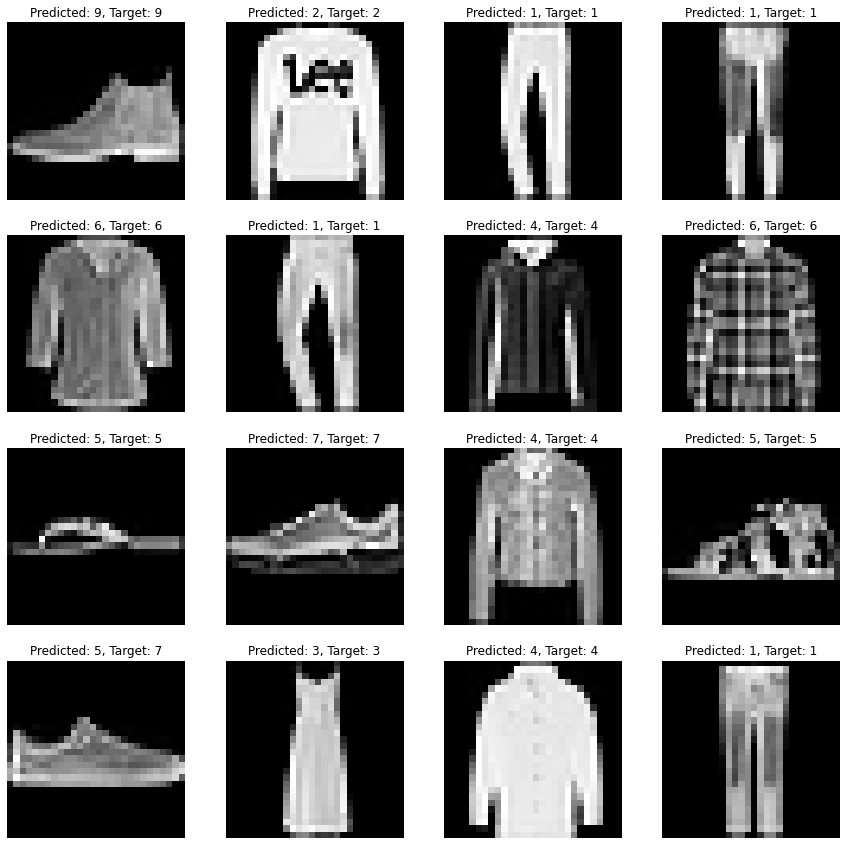

In [14]:
plot()